# Extended Race Car Optimization Models
**Prepared by:** Jiabao Nie (jnie2@nd.edu, 2024) and Your name (jmantoot@nd.edu, 2024)  

In this project, We extend the [Race Car Model](https://ndcbe.github.io/optimization/notebooks/3/PyomoDAE_car.html) introduced in class, which focuses on minimizing travel time for a car to reach a specified distance while adhering to certain constraints. Our extensions introduce three additional elements to enhance the realism and complexity of the model. First, We add a term to account for road friction, which influences the car's acceleration and deceleration in the optimization. Second, We incorporate an uphill and downhill component, modeling the effect of slopes on the car's movement. (Adapted from [The Mountain Car Problem](https://openmdao.github.io/dymos/examples/mountain_car/mountain_car.html).) This factor adjusts the car’s performance based on varying inclines. Lastly, We introduce a gas consumption constraint, adding a new equation to the model that tracks fuel usage. This constraint allows for an optimization that balances speed with fuel efficiency. These extensions provide a more comprehensive view of the optimization problem, offering a closer approximation to real-world driving dynamics.


By the end of this project we hope to:
*   Practice formulating and analyzing optimization problems on paper
*   Develop proficiency in Python and Pyomo
*   Analyze and discuss optimization results


## Install Packages and Load Modules

In [ ]:
# Imports
import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"
    import helper
    helper.easy_install()
else:
    sys.path.insert(0, '../')
    import helper
helper.set_plotting_style()

--2024-10-08 12:54:02--  https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6493 (6.3K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   6.34K  --.-KB/s    in 0s      

2024-10-08 12:54:02 (62.7 MB/s) - ‘helper.py’ saved [6493/6493]

Installing idaes via pip...
idaes was successfully installed
idaes, version 2.6.0


Running idaes get-extensions to install Ipopt, k_aug, and more...
Checking solver versions:
Ipopt 3.13.2 (x86_64-pc-linux-gnu), ASL(20190605)



[K_AUG] 0.1.0, Part of the IDAES PSE framework
Please visit https://idaes.org/ (x86_64-pc-linux-gnu), ASL(20190605)



Couenne 0.5.8 -- an Open-Source solver for Mixed Integer Nonlinear Optimiz

In [ ]:
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import pyomo.dae as dae
from pyomo.environ import units
import numpy as np
import math
from tabulate import tabulate

## Original Model

You are a race car driver with a simple goal. Drive distance $L$ in the minimal amount of time **but** come to a complete stop at the finish line.   

Mathematically, the original optimal control problem was defined as:

$$\begin{align*}
\min_{u} \quad & t_f \\
\mathrm{s.t.} \quad & \frac{dx}{dt} = v \\
& \frac{dv}{dt} = u - R v^2 \\
& x(t=0) = 0, ~~ x(t=t_f) = L \\
& v(t=0) = 0, ~~ v(t=t_f) = 0 \\
& |u| \leq 10
\end{align*}$$

where $u$ is the acceleration/braking (your control variable) and $R$ is the drag coefficient (parameter).   
**Notice:** $Rv^2$ represents aerodynamic drag.

In [ ]:
## Define Original Model
def original_model():
    # Define the  model
    m = pyo.ConcreteModel()

    # Deine the model parameters
    m.R = pyo.Param(initialize=0.001, units=1/units.m)  # Friction factor
    m.L = pyo.Param(initialize=100.0, units=units.m)    # Final position

    # Define time
    m.tau = dae.ContinuousSet(bounds=(0,1))             # Dimensionless time set
    m.tf = pyo.Var(initialize=1, units=units.s)         # Final time

    # Define remaining algebraic variables
    m.x = pyo.Var(m.tau, bounds=(0,m.L+50*units.m), units=units.m)                              # Position
    m.v = pyo.Var(m.tau, bounds=(0,None), units=units.m/units.s)                        # Velocity
    m.u = pyo.Var(m.tau, bounds=(-10.0,10.0),initialize=0, units=units.m/units.s/units.s) # Acceleration

    # Define derivative variables
    m.dx = dae.DerivativeVar(m.x)
    m.dv = dae.DerivativeVar(m.v)

    # Declare the objective (minimize final time)
    m.obj = pyo.Objective(expr=m.tf)

    # Define the constraints
    # position
    def _ode1(m,i):
        if i == 0 :
            return pyo.Constraint.Skip
        return m.dx[i] == m.tf * m.v[i]


    # velocity
    def _ode2(m,i):
        if i == 0 :
            return pyo.Constraint.Skip
        return m.dv[i] == m.tf*(m.u[i] - m.R*m.v[i]**2)
    m.ode2 = pyo.Constraint(m.tau, rule=_ode2)

    # Define the inital/boundary conditions
    def _init(m):
        yield m.x[0] == 0
        yield m.x[1] == m.L
        yield m.v[0] == 0
        yield m.v[1] == 0

    m.initcon = pyo.ConstraintList(rule=_init)

    return m

## Friction Model

### Model Description and Formulation

In the original model, the dynamics of the race car are influenced primarily by the control input $u$, which represents acceleration or braking, and an aerodynamic drag term $R v^2$, which resists motion at higher speeds. However, this approach overlooks additional real-world factors like road friction and tire grip that play a crucial role in the car's performance. To address these aspects and enhance the model's realism, we introduce a frictional component, represented by the term $(Cv+\mu)g$, which captures both constant and velocity-dependent resistance.  
**Objective**: The goal is still to drive distance $L$ in the minimal amount of time **but** come to a complete stop at the finish line.   

Our new problem will be formulated as the following:
$$\begin{align*}
\min_{u} \quad & t_f \\
\mathrm{s.t.} \quad & \frac{dx}{dt} = v \\
& \frac{dv}{dt} = u - R v^2 - (Cv + μ) g \\
& x(t=0) = 0, ~~ x(t=t_f) = L \\
& v(t=0) = 0, ~~ v(t=t_f) = 0\\
&|u| \leq 10\\
\end{align*}$$

 **Constraints**:
1. System dynamics:
   - $ \frac{dx}{dt} = v $: This equation describes how the position $ x $ changes with time, where $ v $ represents the velocity of the system.
   - $ \frac{dv}{dt} = u - R v^2 - (Cv + μ) g $: This describes how the velocity $ v $ evolves over time. The velocity changes according to the control input $u $, the resistance term $ Rv^2 $, and a damping term $ \beta v $.
     - $ u $ is a control variable (acceleration),
     - $ R v^2 $ represents aerodynamic drag,
     - $ (Cv + μ) g $ represents road friction, where $\mu$ is the normal coefficient of friction, and $c>0$ relates to tire deformation or heating effects.

2. Boundary conditions:
   - $ x(0) = 0 $, $ x(t_f) = L $: The position $ x $ is initially at 0, and at time $ t_f $, it must reach $ L $.
   - $ v(0) = 0 $, $v(t_f) = 0 $: The velocity is initially zero and must also be zero at the final time $ t_f $.

3. Control constraints:
   - $ |u| \leq 10 $: The control $ u $ is bounded, meaning the system can only apply a limited amount of control force or acceleration. This constraint ensures that the control input does not exceed certain physical limits.

###  Scale Time

Let $t = τ⋅t_f$ where $τ ∈ [0,1]$. Thus $dt = t_fdτ$. The optimal control problem becomes:  
$$\begin{align*}
\min_{u} \quad & t_f \\
\mathrm{s.t.} \quad & \frac{dx}{dτ} = t_f v \\
& \frac{dv}{dτ} =  t_f [u - R v^2 - (Cv + μ) g] \\
& x(τ=0) = 0, ~~ x(τ=1) = L \\
& v(τ=0) = 0, ~~ v(τ=1) = 0\\
&|u| \leq 10\\
\end{align*}$$

### Declaring Friction Model with Pyomo.DAE

In [ ]:
## Define Friction Model
def friction_model(c,mu):

    # Define the  model
    m = pyo.ConcreteModel()

    # Deine the model parameters
    m.R = pyo.Param(initialize=0.001, units=1/units.m)  # Aerodynamic drag
    m.L = pyo.Param(initialize=100.0, units=units.m)    # Final position
    m.g = pyo.Param(initialize=9.81, units=units.m/units.s/units.s) # Gravity
    m.c = pyo.Param(initialize=c, units=units.s/units.m)       # Tire coefficient
    m.mu = pyo.Param(initialize=mu, units=1)            # Road friction coefficient

    # Define time
    m.tau = dae.ContinuousSet(bounds=(0,1))             # Dimensionless time set
    m.tf = pyo.Var(initialize=1, units=units.s)         # Final time

    # Define remaining algebraic variables
    m.x = pyo.Var(m.tau, bounds=(0,m.L+50*units.m), units=units.m)                              # Position
    m.v = pyo.Var(m.tau, bounds=(0,None), units=units.m/units.s)                        # Velocity
    m.u = pyo.Var(m.tau, bounds=(-10.0,10.0),initialize=0, units=units.m/units.s/units.s) # Acceleration

    # Define derivative variables
    m.dx = dae.DerivativeVar(m.x)
    m.dv = dae.DerivativeVar(m.v)

    # Declare the objective (minimize final time)
    m.obj = pyo.Objective(expr=m.tf)

    # Define the constraints
    # position
    def _ode1(m,i):
        if i == 0 :
            return pyo.Constraint.Skip
        return m.dx[i] == m.tf * m.v[i]
    m.ode1 = pyo.Constraint(m.tau, rule=_ode1)

    # velocity
    def _ode2(m,i):
        if i == 0 :
            return pyo.Constraint.Skip
        return m.dv[i] == m.tf*(m.u[i] - m.R*m.v[i]**2 - (m.c*m.v[i]+m.mu)*m.g)
    m.ode2 = pyo.Constraint(m.tau, rule=_ode2)

    # Define the inital/boundary conditions
    def _init(m):
        yield m.x[0] == 0
        yield m.x[1] == m.L
        yield m.v[0] == 0
        yield m.v[1] == 0

    m.initcon = pyo.ConstraintList(rule=_init)

    return m

### Solve & Plot

Discretize/Transcribe and Solve

In [ ]:
## Discretize and Solve Orignal & Friction
def model_solve(m):

  # Declare the discretizer
  discretizer = pyo.TransformationFactory('dae.collocation')
  discretizer.apply_to(m,nfe=100,scheme='LAGRANGE-RADAU',ncp=3)

  # Solve
  solver = pyo.SolverFactory('ipopt')
  solver.solve(m,tee=False)

  # force piecewise constant controls (acceleration) over each finite element
  m = discretizer.reduce_collocation_points(m,var=m.u,ncp=1,contset=m.tau)

  print("final time = %6.2f seconds" %(pyo.value(m.tf)))

  return m

Extract Data

In [ ]:
## Extract Data and Make List
def data_extract(m):
    # Define empty lists
    x = []    # position, units of length
    v = []    # velocity, units of length per time
    u = []    # acceleration, units of length per time squared
    time=[]   # time
    tf = pyo.value(m.tf)

    # Loop over time and append the solution values for each variable to their respective lists
    for i in m.tau:
        time.append(i*tf)
        x.append(pyo.value(m.x[i]))
        v.append(pyo.value(m.v[i]))
        u.append(pyo.value(m.u[i]))

    return time, x, v, u

Plot Results

In [ ]:
## Plot the Results
def plot_data(data_dict):
    # Make a figure with a specific size
    plt.figure(figsize=(12,4))

    # Format subplot 1 (position)
    plt.subplot(131)
    for key, (time, x, _, _) in data_dict.items():
        plt.plot(time, x, linewidth=3, label=key)
    plt.title('Location (m)', fontsize=16, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=16, fontweight='bold')
    plt.tick_params(direction="in", labelsize=15)

    # Format subplot 2 (velocity)
    plt.subplot(132)
    for key, (time, _, v, _) in data_dict.items():
        plt.plot(time, v, linewidth=3, label=key)
    plt.title('Velocity (m/s)', fontsize=16, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=16, fontweight='bold')
    plt.tick_params(direction="in", labelsize=15)

    # Format subplot 3 (acceleration)
    plt.subplot(133)
    for key, (time, _, _, u) in data_dict.items():
        plt.plot(time, u, linewidth=3, label=key)
    plt.title('Acceleration (m/s$^2$)', fontsize=16, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=16, fontweight='bold')
    plt.tick_params(direction="in", labelsize=15)
    plt.legend(fontsize='small')

    # Display the plots
    plt.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()

### Results
  
We first check the consistency by setting the friction to be 0 in the friction model. Then, we exam the new model with different parameters.

Checking Consistency

final time =   6.33 seconds
final time =   6.33 seconds


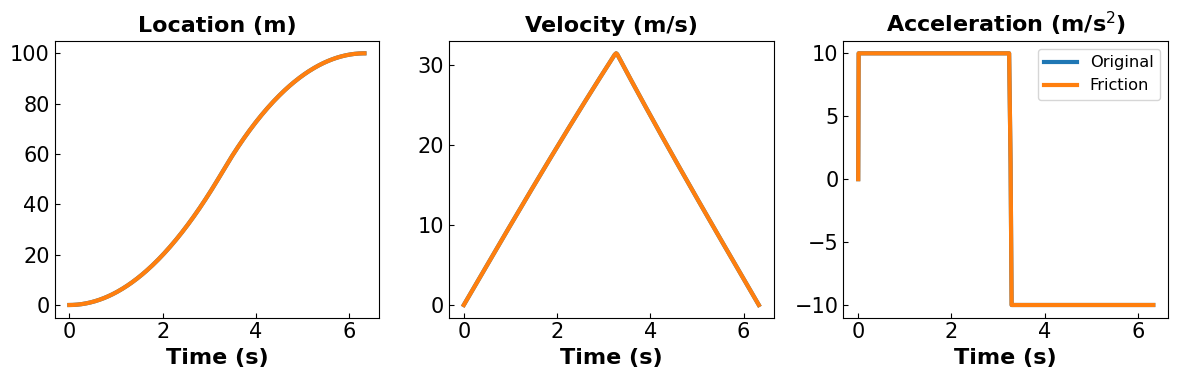

In [ ]:
# Original Model
original_m = original_model()
original_m = model_solve(original_m)
time1, x1, v1, u1 = data_extract(original_m)
# Friction Model with 0 Friction
m_checking = friction_model(0,0)
m_checking = model_solve(m_checking)
time2, x2, v2, u2 = data_extract(m_checking)

data_dict = {
    "Original": (time1, x1, v1, u1),
    "Friction": (time2, x2, v2, u2)
}

plot_data(data_dict)

Different Parameters

+--------+------------------------+-----------------------------+
| Tire   |   Normal Coefficient C |   Deformation Coefficient μ |
+========+========================+=============================+
| Tire 1 |                   0    |                       0     |
+--------+------------------------+-----------------------------+
| Tire 2 |                   0.07 |                       0.002 |
+--------+------------------------+-----------------------------+
| Tire 3 |                   0.04 |                       0.01  |
+--------+------------------------+-----------------------------+
| Tire 4 |                   0.02 |                       0.1   |
+--------+------------------------+-----------------------------+
final time =   6.33 seconds
final time =   8.98 seconds
final time =   7.26 seconds
final time =   6.75 seconds


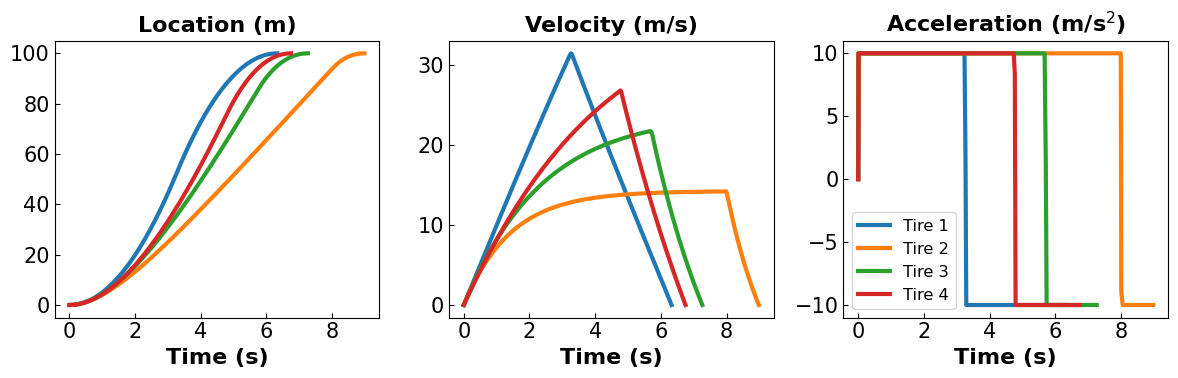

In [ ]:
# Parameter list
c = [0, 0.07, 0.04, 0.02]
mu = [0, 0.002, 0.01, 0.1]

# Table of tires
tire = [
    ["Tire 1", c[0], mu[0]],
    ["Tire 2", c[1], mu[1]],
    ["Tire 3", c[2], mu[2]],
    ["Tire 4", c[3], mu[3]],
]
headers = ["Tire", "Normal Coefficient C", "Deformation Coefficient μ"]
print(tabulate(tire, headers, tablefmt="grid"))

# Create an empty dictionary to store results
data_dict = {}

for i in range(len(c)):
    m_i = friction_model(c[i],mu[i])
    m_i = model_solve(m_i)

    time_i, x_i, v_i, u_i = data_extract(m_i)

    model_label = f"Tire {i+1}"
    data_dict[model_label] = (time_i, x_i, v_i, u_i)

plot_data(data_dict)

## Uphill/Downhill/Flat

### Model Description and Formulation

To further extend the race car model, we account for variations in the road's incline, representing uphill and downhill driving conditions. In real-world scenarios, a slope can significantly affect a car's speed and energy usage. To incorporate this, we add a slope-dependent term that adjusts the car's dynamics based on the angle of the road.    

Specifically, we introduce an incline angle $\phi$ into the velocity equation (Uphill: $\phi>0$, Downhill: $\phi<0$). Now, the model reads as,

$$\begin{align*}
\min_{u} \quad & t_f \\
\mathrm{s.t.} \quad & \frac{dx}{dt} = v \\
& \frac{dv}{dt} = u - g\sin(ϕ)- R v^2 - (Cv + \mu)g\cos(ϕ)  \\
& x(t=0) = 0, ~~ x(t=t_f) = L \\
& v(t=0) = 0, ~~ v(t=t_f) = 0 \\
& |u| \leq 10
\end{align*}$$  

This adjustment allows the model to simulate how an uphill climb or downhill descent impacts the car's performance, adding another layer of complexity to the optimization problem. By considering the slope, we achieve a more comprehensive model that reflects the real-world effects of changing terrain on travel time and energy requirements.

### Declaring Uphill/Downhill Model with Pyomo.DAE

In [ ]:
## Define Friction Model
def friction_uphill_model(c,mu,phi):

    # Define the  model
    m = pyo.ConcreteModel()

    # Deine the model parameters
    m.R = pyo.Param(initialize=0.001, units=1/units.m)  # Aerodynamic drag
    m.L = pyo.Param(initialize=100.0, units=units.m)    # Final position
    m.g = pyo.Param(initialize=9.81, units=units.m/units.s/units.s) # Gravity
    m.c = pyo.Param(initialize=c, units=units.s/units.m)       # Tire coefficient
    m.mu = pyo.Param(initialize=mu, units=1)            # Road friction coefficient

    # Define time
    m.tau = dae.ContinuousSet(bounds=(0,1))             # Dimensionless time set
    m.tf = pyo.Var(initialize=1, units=units.s)         # Final time

    # Define remaining algebraic variables
    m.x = pyo.Var(m.tau, bounds=(0,m.L+50*units.m), units=units.m)                              # Position
    m.v = pyo.Var(m.tau, bounds=(0,None), units=units.m/units.s)                        # Velocity
    m.u = pyo.Var(m.tau, bounds=(-10.0,10.0),initialize=0, units=units.m/units.s/units.s) # Acceleration

    # Define derivative variables
    m.dx = dae.DerivativeVar(m.x)
    m.dv = dae.DerivativeVar(m.v)

    # Declare the objective (minimize final time)
    m.obj = pyo.Objective(expr=m.tf)

    # Define the constraints
    # position
    def _ode1(m,i):
        if i == 0 :
            return pyo.Constraint.Skip
        return m.dx[i] == m.tf * m.v[i]
    m.ode1 = pyo.Constraint(m.tau, rule=_ode1)

    # velocity
    def _ode2(m,i):
        if i == 0 :
            return pyo.Constraint.Skip
        return m.dv[i] == m.tf*(m.u[i] - m.g*np.sin(phi) - m.R*m.v[i]**2 - (m.c*m.v[i]+m.mu)*m.g*np.cos(phi))
    m.ode2 = pyo.Constraint(m.tau, rule=_ode2)

    # Define the inital/boundary conditions
    def _init(m):
        yield m.x[0] == 0
        yield m.x[1] == m.L
        yield m.v[0] == 0
        yield m.v[1] == 0

    m.initcon = pyo.ConstraintList(rule=_init)

    return m

### Results

Checking Consistency

final time =   6.40 seconds
final time =   6.40 seconds


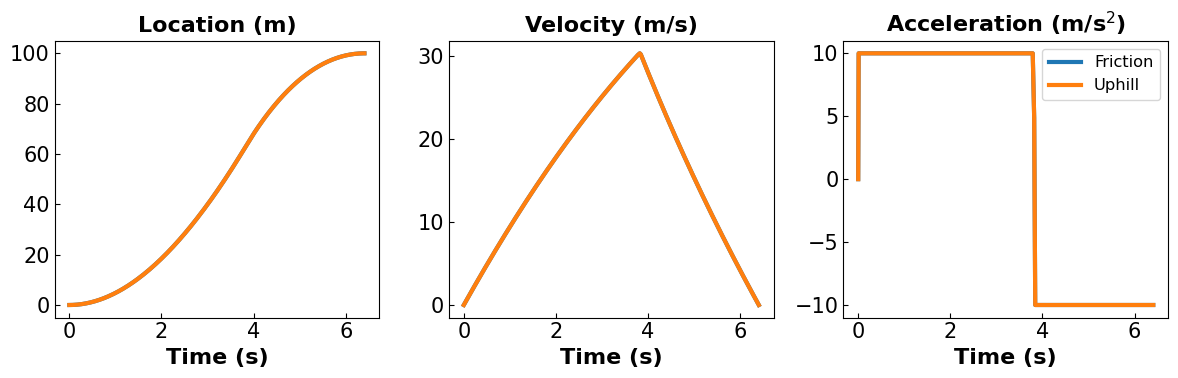

In [ ]:
# Friction Model
m_friction = friction_model(0.01,0.01)
m_friction = model_solve(m_friction)
time1, x1, v1, u1 = data_extract(m_friction)

# Uphill Model with 0 Slope
m_checking = friction_uphill_model(0.01,0.01,0.0)
m_checking = model_solve(m_checking)
time2, x2, v2, u2 = data_extract(m_checking)

data_dict = {
    "Friction": (time1, x1, v1, u1),
    "Uphill": (time2, x2, v2, u2)
}

plot_data(data_dict)

Different Slopes (uphill:positive , downhills:negative)

final time =   6.88 seconds
final time =   6.40 seconds
final time =   6.40 seconds
final time =   6.84 seconds
final time =   7.82 seconds


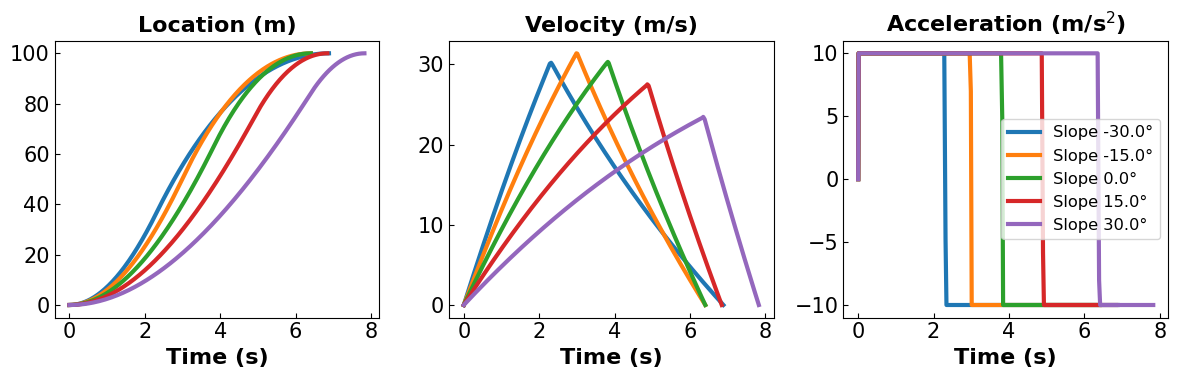

In [ ]:
# Parameter list
phi = [-np.pi/6,-np.pi/12, 0, np.pi/12, np.pi/6]

# Create an empty dictionary to store results
data_dict1 = {}

for i, angle in enumerate(phi):
    # Create and solve the model for each angle
    m_i = friction_uphill_model(0.01, 0.01, angle)
    m_i = model_solve(m_i)

    # Extract the data
    time_i, x_i, v_i, u_i = data_extract(m_i)

    # Convert the angle to degrees for a clearer label
    angle_deg = np.degrees(angle)
    model_label = f"Slope {angle_deg:.1f}°"

    # Store the data in the dictionary
    data_dict1[model_label] = (time_i, x_i, v_i, u_i)

plot_data(data_dict1)

## Gas Consumption Model

### Model Description and Formulation

Building on the basic race car model, we now introduce fuel consumption as an additional constraint. In real-world scenarios, energy efficiency is critical, especially in racing, where maintaining acceleration and minimizing fuel usage are both essential. By modeling fuel consumption, we can further refine our control strategy to include energy constraints.  
  
To account for fuel consumption in our race car model, we calculate the power $P$ (in watts, $W$) required to maintain the car's acceleration. This power demand depends on the control input $u$, road slope, aerodynamic drag, and friction. We can express $P$ as:
$$\begin{equation*}
P = m ⋅ v⋅ [|u|  +g\sin(ϕ)+R v^2 + (Cv + \mu)g\cos(ϕ)]
\end{equation*}$$
The gas $G$ (in liters, $L$) required to provide this amount of power can be modeled by:
$$\begin{equation*}
\frac{dG}{dt} = - k ⋅ P
\end{equation*}$$
where $k=\eta ⋅ r$ (with units $L/J$) is the gas consumption factor. $\eta < 1$ represents the engine efficiency (unit: 1) and $r$ is the gas consumption coefficient (unit: $L/J$), defined as the volume of fuel consumed per joule of energy produced.

Given these definitions, our extended optimization problem becomes:
$$\begin{align*}
\min_{u} \quad & t_f \\
\mathrm{s.t.} \quad & \frac{dx}{dt} = v \\
& \frac{dv}{dt} = u - R v^2 - (Cv + μ)g \\
&\frac{dG}{dt}= - d ⋅ v⋅[|u|  +g\sin(ϕ)+R v^2 + (Cv + \mu)g\cos(ϕ)] \\
& x(t=0) = 0, ~~ x(t=t_f) = L \\
& v(t=0) = 0, ~~ v(t=t_f) = 0\\
& G(t=0) = G_0, ~~ G(t) \geq 0\\
&|u| \leq 10
\end{align*}$$  
  
In this setup, we aim to minimize the final time $t_f$ while satisfying the car’s motion and fuel consumption constraints. The term $\frac{dG}{dt}$ ensures that gas consumption is accounted for, making the model more realistic by introducing an energy efficiency constraint.

### Scale Time

Let $t = τ⋅t_f$ where $τ ∈ [0,1]$. Thus $dt = t_fdτ$. The optimal control problem becomes:  
$$\begin{align*}
\min_{u} \quad & t_f \\
\mathrm{s.t.} \quad & \frac{dx}{dτ} = t_f v \\
& \frac{dv}{dτ} =  t_f [u - R v^2 - (Cv + μ) g] \\
&\frac{dG}{dτ}= - d t_f ⋅v⋅[|u|  +g\sin(ϕ)+R v^2 + (Cv + \mu)g\cos(ϕ)] \\
& x(τ=0) = 0, ~~ x(τ=1) = L \\
& v(τ=0) = 0, ~~ v(τ=1) = 0\\
& G(τ=0) = G_0, ~~ G(τ) \geq 0\\
&|u| \leq 10
\end{align*}$$

### Declaring Gas Consumption Model with Pyomo.DAE

In [ ]:
## Define Gas Consumption Model
def gas_consumption_model(c,mu,G_initial,phi):

    # Define the  model
    m = pyo.ConcreteModel()

    # Deine the model parameters
    m.R = pyo.Param(initialize=0.001, units=1/units.m)  # Aerodynamic drag
    m.L = pyo.Param(initialize=100.0, units=units.m)    # Final position
    m.g = pyo.Param(initialize=9.81, units=units.m/units.s/units.s) # Gravity
    m.c = pyo.Param(initialize=c, units=units.s/units.m)       # Tire coefficient
    m.mu = pyo.Param(initialize=mu, units=1)            # Road friction coefficient
    m.d = pyo.Param(initialize=1, units=units.L/units.J)    # Gas consumption coefficient

    # Define time
    m.tau = dae.ContinuousSet(bounds=(0,1))             # Dimensionless time set
    m.tf = pyo.Var(initialize=1, units=units.s)         # Final time

    # Define remaining algebraic variables
    m.x = pyo.Var(m.tau, bounds=(0,m.L+50*units.m), units=units.m)                              # Position
    m.v = pyo.Var(m.tau, bounds=(0,None), units=units.m/units.s)                        # Velocity
    m.u = pyo.Var(m.tau, bounds=(-10.0,10.0),initialize=0, units=units.m/units.s/units.s) # Acceleration
    m.G = pyo.Var(m.tau, bounds=(0,G_initial), units=units.L)                                # Gas consumption

    # Define derivative variables
    m.dx = dae.DerivativeVar(m.x)
    m.dv = dae.DerivativeVar(m.v)
    m.dG = dae.DerivativeVar(m.G)

    # Declare the objective (minimize final time)
    m.obj = pyo.Objective(expr=m.tf)

    # Define the constraints
    # position
    def _ode1(m,i):
        if i == 0 :
            return pyo.Constraint.Skip
        return m.dx[i] == m.tf * m.v[i]
    m.ode1 = pyo.Constraint(m.tau, rule=_ode1)

    # velocity
    def _ode2(m,i):
        if i == 0 :
            return pyo.Constraint.Skip
        return m.dv[i] == m.tf*(m.u[i] - m.g*np.sin(phi) - m.R*m.v[i]**2 - (m.c*m.v[i]+m.mu)*m.g*np.cos(phi))
    m.ode2 = pyo.Constraint(m.tau, rule=_ode2)

    # gas consumption
    def _ode3(m,i):
        if i == 0 :
            return pyo.Constraint.Skip
        return m.dG[i] == - m.d * m.tf *m.v[i] *(abs(m.u[i])+ m.g*np.sin(phi) + m.R*m.v[i]**2 + (m.c*m.v[i]+m.mu)*m.g*np.cos(phi))
    m.ode3 = pyo.Constraint(m.tau, rule=_ode3)


    # Define the inital/boundary conditions
    def _init(m):
        yield m.x[0] == 0
        yield m.x[1] == m.L
        yield m.v[0] == 0
        yield m.v[1] == 0
        yield m.G[0] == G_initial

    m.initcon = pyo.ConstraintList(rule=_init)

    return m

### Plot Function

Extrcat Data

In [ ]:
## Extract Data and Make List
def data_gas(m):
    # Define empty lists
    x = []    # position, units of length
    v = []    # velocity, units of length per time
    u = []    # acceleration, units of length per time squared
    G = []    # gas consumption, units of length per time squared
    time=[]   # time
    tf = pyo.value(m.tf)

    # Loop over time and append the solution values for each variable to their respective lists
    for i in m.tau:
        time.append(i*tf)
        x.append(pyo.value(m.x[i]))
        v.append(pyo.value(m.v[i]))
        u.append(pyo.value(m.u[i]))
        G.append(pyo.value(m.G[i]))

    return time, x, v, u, G

Plot

In [ ]:
## Plot the Results
def plot_gas(data_dict):
    # Make a figure with a specific size
    plt.figure(figsize=(8,8))

    # Format subplot 1 (position)
    plt.subplot(221)
    for key, (time, x, _, _, _) in data_dict.items():
        plt.plot(time, x, linewidth=3, label=key)
    plt.title('Location (m)', fontsize=16, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=16, fontweight='bold')
    plt.tick_params(direction="in", labelsize=15)

    # Format subplot 2 (velocity)
    plt.subplot(222)
    for key, (time, _, v, _, _) in data_dict.items():
        plt.plot(time, v, linewidth=3, label=key)
    plt.title('Velocity (m/s)', fontsize=16, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=16, fontweight='bold')
    plt.tick_params(direction="in", labelsize=15)

    # Format subplot 3 (acceleration)
    plt.subplot(223)
    for key, (time, _, _, u, _) in data_dict.items():
        plt.plot(time, u, linewidth=3, label=key)
    plt.title('Acceleration (m/s$^2$)', fontsize=16, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=16, fontweight='bold')
    plt.tick_params(direction="in", labelsize=15)

    # Format subplot 4 (gas)
    plt.subplot(224)
    for key, (time, _, _, _, G) in data_dict.items():
        plt.plot(time, G, linewidth=3, label=key)
    plt.title('Gas Consumption (L)', fontsize=16, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=16, fontweight='bold')
    plt.tick_params(direction="in", labelsize=15)
    plt.legend()

    # Display the plots
    plt.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()

### Results

Checking Consistency with enough gas

final time =  58.58 seconds
final time =  58.58 seconds


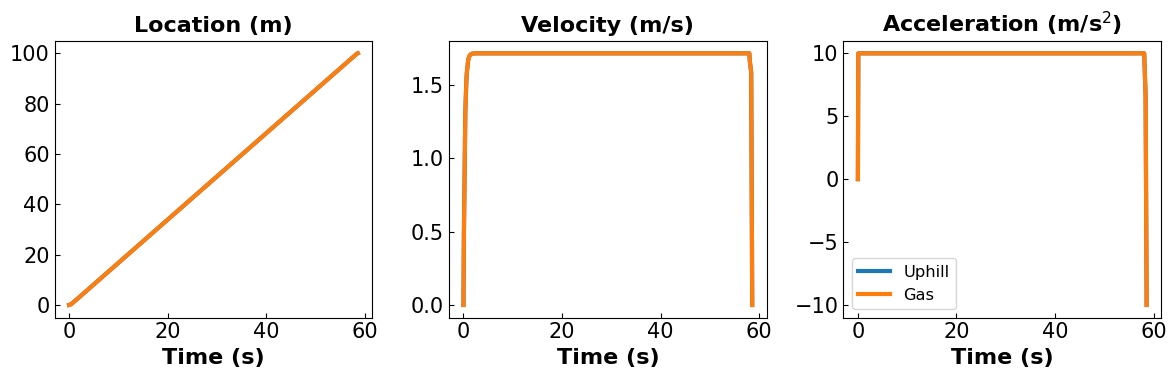

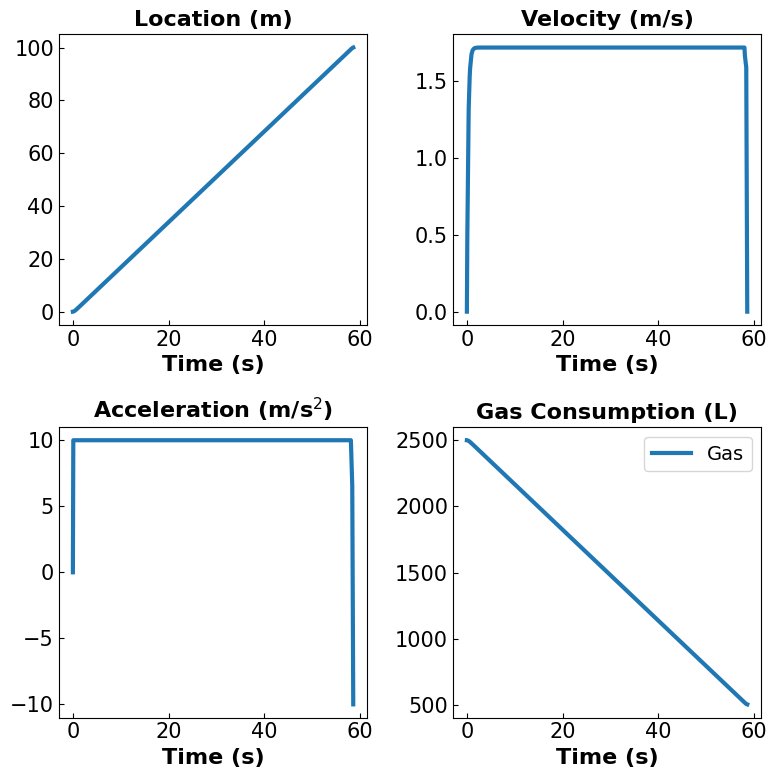

In [ ]:
# Uphill Model
m_checking = friction_uphill_model(0.4,0.1,np.pi/12)
m_checking = model_solve(m_checking)
time1, x1, v1, u1 = data_extract(m_checking)

# Gas Consumption Model with Enough Gas
m_gas = gas_consumption_model(0.4,0.1,2500,np.pi/12)
m_gas = model_solve(m_gas)
time2, x2, v2, u2 = data_extract(m_gas)
time3, x3, v3, u3, G3 = data_gas(m_gas)

data_dict1 = {
    "Uphill": (time1, x1, v1, u1),
    "Gas": (time2, x2, v2, u2)
}

data_dict2 = {
    "Gas": (time3, x3, v3, u3, G3)
}

plot_data(data_dict1)
plot_gas(data_dict2)

Different amounts of gas

final time =  94.62 seconds
final time =  68.95 seconds
final time =  58.58 seconds


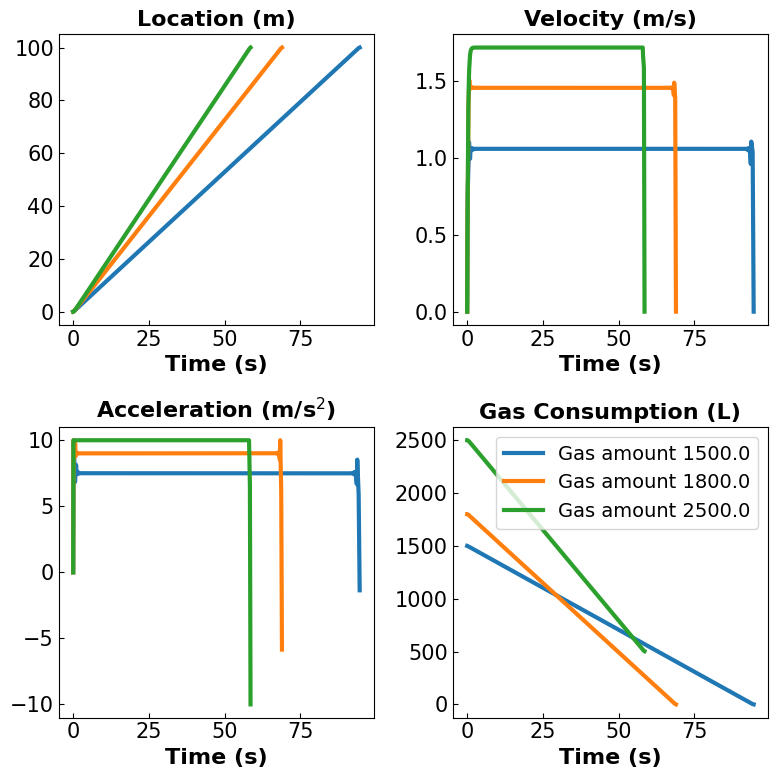

In [ ]:
angle = np.pi/12
gas = [1500,1800,2500]
data_dict2 = {}

for i, gas in enumerate(gas):
    # Create and solve the model for each angle
    m_i = gas_consumption_model(0.4,0.1,gas, angle)
    m_i = model_solve(m_i)

    # Extract the data
    time_i, x_i, v_i, u_i,g_i = data_gas(m_i)

    # Convert the angle to degrees for a clearer label
    angle_deg = np.degrees(angle)
    model_label = f"Gas amount {gas:.1f}"

    # Store the data in the dictionary
    data_dict2[model_label] = (time_i, x_i, v_i, u_i, g_i)


plot_gas(data_dict2)

## Conclusion  

In conclusion, this project has expanded upon the basic race car optimization model by incorporating realistic physical effects such as road friction, slope, and fuel consumption constraints. Through these extensions, we can gain insights into how different factors impact the optimized performance of the race car in a competitive scenario.

First, we observed that changing tire properties affects the optimized time to complete the course. Tires with different coefficients 
$c$ and $\mu$ in the friction model lead to variations in road friction and, consequently, impact the optimal control strategy. Higher friction coefficients, for example, demand a greater effort to maintain speed, potentially increasing the minimum achievable time.

Second, the addition of an uphill/downhill model shows that climbing costs additional time due to the gravitational component acting against the car's motion. Uphill sections require more power to counteract gravity, slowing down the car even with an optimal control strategy, while downhill sections can allow faster movement with less acceleration.

Lastly, fuel constraints play a significant role in determining the achievable performance. With a sufficient fuel supply, the car can perform at its best, closely matching the behavior of the original model without fuel limitations. However, when the fuel is limited, achieving the target distance becomes a matter of balancing speed and fuel efficiency. By carefully managing acceleration, the car can still reach the destination within its fuel constraints, albeit at a reduced speed. This highlights the trade-off between speed and energy efficiency when resources are constrained.

Overall, these extensions bring the model closer to real-world applications, demonstrating how optimal control strategies must adapt to varying conditions and limitations. This enriched model can be applied to explore further scenarios and parameter variations, providing valuable insights into performance optimization in constrained environments.

## References

> Michael L. Bynum, Gabriel A. Hackebeil, William E. Hart, Carl D. Laird, Bethany L.
Nicholson, John D. Siirola, and David L. Woodruff. Pyomo — Optimization Modeling in
Python. Springer Optimization and Its Applications. Springer, Cham, 3 edition, 2021.


> Benedek Csercsik. Pyomo.dae car example. https://ndcbe.github.io/optimization/
notebooks/3/PyomoDAE_car.html. Accessed: 2024-09-05.



> OpenMDAO Development Team. Dymos mountain car example. https://openmdao.
github.io/dymos/examples/mountain_car/mountain_car.html. Accessed: 2024-09-05.





